In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import decomposition
import gym

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# envname = 'MountainCarContinuous-v0'
envname = 'Pendulum-v0'
demo_file = open('./'+envname+'-demo.pkl', 'rb')
demonstrations = pickle.load(demo_file)[0]

In [11]:
class LatentDynamicModel(object):
    def __init__(self, obs_dim, act_dim, hdim = 64, ldim = 64, epochs = 100000, lr = 1e-8):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.seed = 0
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.next_obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'next_obs')
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        control_size = self.hdim
        
        with tf.variable_scope("encoder"):
            # Encoder
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
            self.latent = tf.layers.dense(out, latent_size,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="latent")

            # Encoder for next state
            out = tf.layers.dense(self.next_obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=True)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=True)
            self.next_latent = tf.layers.dense(out, latent_size,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="latent",reuse=True)
            
        with tf.variable_scope("passive_dynamics"):
            # Control Dynamics
            out = tf.layers.dense(self.latent, control_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            self.passive_dynamics = tf.layers.dense(out, latent_size,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="flatten_dynamics")
            
        with tf.variable_scope("control_dynamics"):
            # Control Dynamics
            out = tf.layers.dense(self.latent, control_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, latent_size*self.act_dim,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="flatten_dynamics")
            self.control_dynamics = tf.reshape(out,[-1,latent_size,self.act_dim], name="control_dynamics")
        self.next_latent_predict = self.latent + self.passive_dynamics + tf.reduce_sum(self.control_dynamics*tf.tile(self.act_ph[:,tf.newaxis,:],[1,latent_size,1]))
        
        with tf.variable_scope("decoder"):
            # Decoder
            out = tf.layers.dense(self.latent_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
            self.dec_obs = tf.layers.dense(out, self.obs_dim,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="obs")

            # Decoder for next state
            out = tf.layers.dense(self.next_latent_predict, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=True)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=True)
            self.next_dec_obs = tf.layers.dense(out, self.obs_dim,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="obs",reuse=True)
        
    def _loss_train_op(self):
        # Define Loss
        reconstruction_loss = tf.reduce_sum(tf.squared_difference(self.dec_obs,self.obs_ph))
        obs_prediction_loss = tf.reduce_sum(tf.squared_difference(self.next_dec_obs,self.next_obs_ph))
        latent_prediction_loss = tf.reduce_sum(tf.squared_difference(self.next_latent_predict,self.next_latent))
        smoothness_loss = tf.reduce_sum(tf.squared_difference(self.latent,self.next_latent))
        
        self.reconstruction_loss = reconstruction_loss
        self.obs_prediction_loss = obs_prediction_loss
        self.latent_prediction_loss = latent_prediction_loss
        self.smoothness_loss = smoothness_loss
        
        # Sum up
        total_loss = reconstruction_loss + latent_prediction_loss
        self.loss = tf.reduce_mean(total_loss)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
        
    def get_latent(self,obs):
        return self.sess.run(self.latent,feed_dict={self.obs_ph:obs})
    
    def get_recon_obs(self,latent):
        return self.sess.run(self.dec_obs,feed_dict={self.latent_ph:latent})
    
    def get_prediction(self,obs,act):
        next_latent = self.sess.run(self.next_latent_predict,feed_dict={self.obs_ph:obs,self.act_ph:act})
        return self.sess.run(self.dec_obs,feed_dict={self.latent_ph:next_latent})
    
    def get_control_dynamics(self,obs):
        return self.sess.run(self.control_dynamics,feed_dict={self.obs_ph:obs})
    
#     def get_prediction_trajectory(self,obs,actions):
        
#         for act in actions
    
    def train(self,obs,act,next_obs,batch_size = 128): # TRAIN POLICY
        
        num_batches = max(obs.shape[0] // batch_size, 1)
        batch_size = obs.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            obs,act,next_obs = shuffle(obs,act,next_obs,random_state=0)
            latent_np = self.get_latent(obs)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: obs[start:end,:],
                     self.act_ph: act[start:end,:],
                     self.next_obs_ph: next_obs[start:end,:],
                     self.latent_ph: latent_np[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if (e%500)==0:
                feed_dict = {self.obs_ph: obs,
                     self.act_ph: act,
                     self.next_obs_ph: next_obs,
                     self.latent_ph: latent_np,
                     self.lr_ph: self.lr} 
                total_loss, recon, obs_predict, latent_predict, smoothness = self.sess.run([self.loss,self.reconstruction_loss, self.obs_prediction_loss, self.latent_prediction_loss, self.smoothness_loss], feed_dict)
                print('[{}/{}] Total : {:.03f} Recon : {:.03f}, Prediction : {:.03f}, Latent Prediction : {:.03f}, Smoothness : {:.03f}'.
                      format(e, self.epochs, total_loss, recon, obs_predict, latent_predict, smoothness))
        return recon, obs_predict, latent_predict, smoothness, total_loss

In [12]:
env = gym.make(envname)

env.seed(seed=0)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

ldm = LatentDynamicModel(obs_dim,act_dim)

[2018-06-20 11:08:36,019] Making new env: Pendulum-v0


In [13]:
obs = np.concatenate([t['observes'][:-1] for t in demonstrations])
act = np.concatenate([t['actions'][:-1] for t in demonstrations])
next_obs = np.concatenate([t['observes'][1:] for t in demonstrations])
print(obs.shape)
print(act.shape)
print(next_obs.shape)

(19900, 3)
(19900, 1)
(19900, 3)


In [14]:
ldm.train(obs,act,next_obs)

[0/100000] Total : 68501.992 Recon : 66108.727, Prediction : 66070.906, Latent Prediction : 2393.264, Smoothness : 0.000
[500/100000] Total : 66065.820 Recon : 66065.562, Prediction : 66028.211, Latent Prediction : 0.260, Smoothness : 0.000
[1000/100000] Total : 66018.016 Recon : 66018.016, Prediction : 65980.367, Latent Prediction : 0.003, Smoothness : 0.000
[1500/100000] Total : 65965.703 Recon : 65965.703, Prediction : 65927.742, Latent Prediction : 0.001, Smoothness : 0.000
[2000/100000] Total : 65908.273 Recon : 65908.273, Prediction : 65869.961, Latent Prediction : 0.002, Smoothness : 0.000
[2500/100000] Total : 65845.398 Recon : 65845.344, Prediction : 65806.648, Latent Prediction : 0.058, Smoothness : 0.000
[3000/100000] Total : 65776.656 Recon : 65776.656, Prediction : 65737.539, Latent Prediction : 0.003, Smoothness : 0.000
[3500/100000] Total : 65701.781 Recon : 65701.781, Prediction : 65662.195, Latent Prediction : 0.000, Smoothness : 0.000
[4000/100000] Total : 65620.461 R

[34000/100000] Total : 51959.410 Recon : 51959.410, Prediction : 51750.383, Latent Prediction : 0.001, Smoothness : 0.000
[34500/100000] Total : 51958.473 Recon : 51958.473, Prediction : 51749.277, Latent Prediction : 0.000, Smoothness : 0.000
[35000/100000] Total : 51957.711 Recon : 51957.711, Prediction : 51748.410, Latent Prediction : 0.000, Smoothness : 0.000
[35500/100000] Total : 51957.086 Recon : 51957.086, Prediction : 51747.742, Latent Prediction : 0.000, Smoothness : 0.000
[36000/100000] Total : 51956.562 Recon : 51956.562, Prediction : 51747.164, Latent Prediction : 0.002, Smoothness : 0.000
[36500/100000] Total : 51956.125 Recon : 51956.125, Prediction : 51746.742, Latent Prediction : 0.001, Smoothness : 0.000
[37000/100000] Total : 51955.762 Recon : 51955.762, Prediction : 51746.359, Latent Prediction : 0.000, Smoothness : 0.000
[37500/100000] Total : 51955.453 Recon : 51955.453, Prediction : 51746.027, Latent Prediction : 0.000, Smoothness : 0.000
[38000/100000] Total : 5

[68000/100000] Total : 51954.008 Recon : 51954.008, Prediction : 51744.520, Latent Prediction : 0.000, Smoothness : 0.000
[68500/100000] Total : 51954.004 Recon : 51954.004, Prediction : 51744.492, Latent Prediction : 0.000, Smoothness : 0.000
[69000/100000] Total : 51954.012 Recon : 51954.008, Prediction : 51744.555, Latent Prediction : 0.002, Smoothness : 0.000
[69500/100000] Total : 51954.016 Recon : 51954.016, Prediction : 51744.477, Latent Prediction : 0.001, Smoothness : 0.000
[70000/100000] Total : 51954.020 Recon : 51954.020, Prediction : 51744.488, Latent Prediction : 0.000, Smoothness : 0.000
[70500/100000] Total : 51954.031 Recon : 51954.027, Prediction : 51744.590, Latent Prediction : 0.003, Smoothness : 0.000
[71000/100000] Total : 51954.262 Recon : 51954.027, Prediction : 51745.230, Latent Prediction : 0.234, Smoothness : 0.000
[71500/100000] Total : 51954.039 Recon : 51954.031, Prediction : 51744.617, Latent Prediction : 0.006, Smoothness : 0.000
[72000/100000] Total : 5

(51954.15, 51744.625, 2.7470633e-05, 1.4090455e-06, 51954.15)

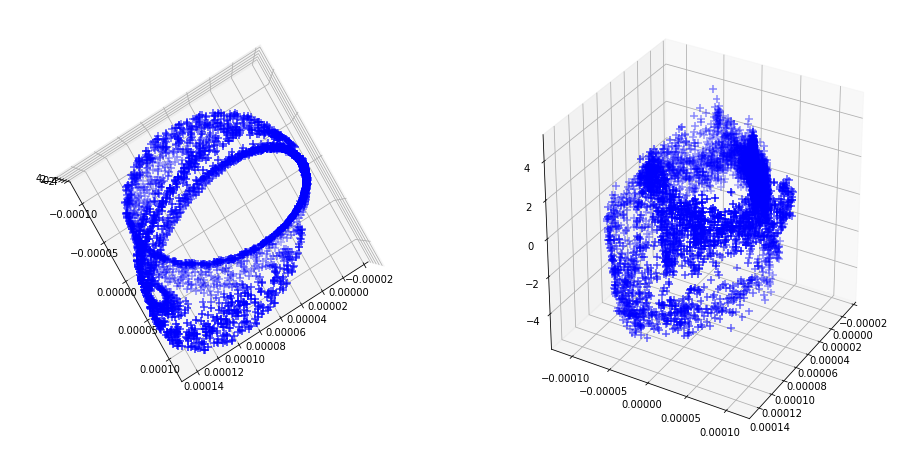

In [7]:
latent = ldm.get_latent(obs)
pca = decomposition.PCA(n_components=2)
pca.fit(latent)
observes_demo_pca = pca.transform(latent)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(90, 60)
plt.scatter(observes_demo_pca[:,0],observes_demo_pca[:,1],zs=act,marker='+',linewidths=1,s=60,c='b')
ax = fig.add_subplot(122, projection='3d')
ax.view_init(30, 30)
plt.scatter(observes_demo_pca[:,0],observes_demo_pca[:,1],zs=act,marker='+',linewidths=1,s=60,c='b')
plt.show()

In [15]:
class Value(object):
    def __init__(self, obs_dim, act_dim, hdim = 128, ldim = 64, epochs = 20000, lr = 1e-6):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.seed = 0
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.control_dynamics_ph = tf.placeholder(tf.float32, (None, self.ldim, self.act_dim), 'control_dynamics')
        self.control_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'control')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("value_network"):
            # Encoder
            out = tf.layers.dense(self.latent_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
            self.value = tf.layers.dense(out, 1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="value")
            self.value_gradients = tf.gradients(self.value,self.latent_ph,name="value_grads")[0]
            self.control = - tf.reduce_sum(tf.tile(self.value_gradients[:,:,tf.newaxis],[1,1,self.act_dim])*self.control_dynamics_ph,axis=1)

    def _loss_train_op(self):        
        # Sum up
        loss = tf.square(self.control_ph - self.control)
        self.loss = tf.reduce_mean(loss)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
    
    def get_control(self,latent,control_dynamics):
        ctrl, val = self.sess.run([self.control, self.value],feed_dict={self.latent_ph:latent,self.control_dynamics_ph:control_dynamics})
        return ctrl, val
#     def get_prediction_trajectory(self,obs,actions):
        
#         for act in actions
    
    def train(self,latent,control_dynamics,control,batch_size = 32): # TRAIN POLICY
        
        num_batches = max(obs.shape[0] // batch_size, 1)
        batch_size = obs.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            latent,control_dynamics,control = shuffle(latent,control_dynamics,control,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.latent_ph: latent[start:end,:],
                     self.control_dynamics_ph: control_dynamics[start:end,:,:],
                     self.control_ph: control[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if (e%1000)==0:
                feed_dict = {self.latent_ph: latent,
                     self.control_dynamics_ph: control_dynamics,
                     self.control_ph: control}        
                loss = self.sess.run(self.loss, feed_dict)
                print('[{}/{}] Loss : {:.05f}'.
                      format(e, self.epochs, loss))
        return loss

In [ ]:
value = Value(obs_dim,act_dim)

latent = ldm.get_latent(obs)
control_dynamics = ldm.get_control_dynamics(obs)
# value.epochs = 3000
value.train(latent,control_dynamics,act)

[0/20000] Loss : 0.89886
[1000/20000] Loss : 0.89886
[2000/20000] Loss : 0.89797
[3000/20000] Loss : 0.89029
[4000/20000] Loss : 0.86997
[5000/20000] Loss : 0.83666
[6000/20000] Loss : 0.79670
[7000/20000] Loss : 0.76071


-1038.1816


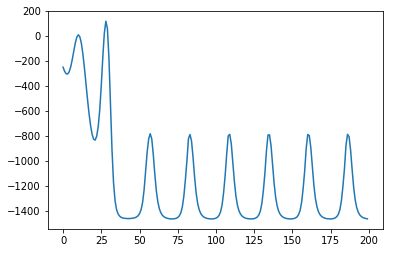

In [10]:
obs = env.reset()
rewards = []
vals = []
done = False
while not done:
    
    latent = ldm.get_latent([obs])
    control_dynamic = ldm.get_control_dynamics([obs])
    action, val = value.get_control(latent,control_dynamic)
    
    obs, reward, done, info = env.step(action)
    obs = np.squeeze(obs)
    rewards.append(reward)
    vals.append(val[0][0])

print(np.sum(rewards))
plt.plot(vals)
plt.show()